# cell_type

In [65]:
import logging
import typing as t
from functools import lru_cache
from logging import log

import networkx as nx
import owlready2
from scipy import sparse as sp

import numpy as np
import torch
import pandas as pd
import pandas_gbq
from google.cloud import bigquery
import matplotlib.pyplot as plt

In [66]:
# Query template format
query_format = """
    select {column_name}, count(*) as num_cells 
    from `cas_2024_05_16_dataset.human_cellariumgpt_extract__extract_cell_info`
    group by {column_name}
    order by num_cells desc
"""

In [67]:
def get_ancestors_csr_matrix(graph, names_to_idx_map: t.Dict[str, int]) -> sp.csr_matrix:
    """Returns a sparse matrix representation of ancestors.

    .. note:
        The matrix element (i, j) = 1 iff j is an ancetor of i.
    """
    n_nodes = len(graph.nodes)

    row = []
    col = []
    data = []

    for name, self_idx in names_to_idx_map.items():
        row.append(self_idx)
        col.append(self_idx)
        data.append(1)
        for ancestor_name in nx.ancestors(graph, name):
            ancestor_idx = names_to_idx_map[ancestor_name]
            row.append(self_idx)
            col.append(ancestor_idx)
            data.append(1)

    ancestors_csr_matrix = sp.csr_matrix((data, (row, col)), shape=(n_nodes, n_nodes))
    return ancestors_csr_matrix

In [68]:
def get_shortest_distances_matrix(graph, names_to_idx_map: t.Dict[str, int]) -> np.ndarray:
    """Returns a sparse matrix representation of shortest distances.

    .. note:
        The matrix element (i, j) = d iff d is the shortest distance between i and j.
    """
    n_nodes = len(graph.nodes)

    distance_matrix = np.full((n_nodes, n_nodes), np.inf)

    for target, value in dict(nx.all_pairs_shortest_path_length(graph)).items():
        for source, distance in value.items():
            source_idx = names_to_idx_map[source]
            target_idx = names_to_idx_map[target]
            distance_matrix[source_idx, target_idx] = distance
            distance_matrix[target_idx, source_idx] = distance

    return distance_matrix

In [4]:
# def get_shortest_path_lengths_from_source(graph, source: str) -> t.Dict[str, float]:
#     # Perform a topological sort of the graph
#     topo_order = list(nx.topological_sort(graph))

#     # Initialize distances with infinity for all nodes except the source
#     distances = {node: float("inf") for node in graph.nodes()}
#     distances[source] = 0

#     # Process nodes in reverse topological order
#     for node in reversed(topo_order):
#         if distances[node] != float("inf"):  # Only process reachable nodes
#             for neighbor in graph.predecessors(node):
#                 if distances[neighbor] > distances[node] + 1:
#                     distances[neighbor] = distances[node] + 1

#     return distances

In [5]:
# def get_longest_path_lengths_from_source(graph, source: str) -> t.Dict[str, float]:
#     # Perform a topological sort of the graph
#     topo_order = list(nx.topological_sort(graph))

#     # Initialize distances with -infinity for all nodes except the source
#     distances = {node: float("-inf") for node in graph.nodes()}
#     distances[source] = 0

#     # Process nodes in reverse topological order
#     for node in reversed(topo_order):
#         if distances[node] != float("-inf"):  # Only process reachable nodes
#             for neighbor in graph.predecessors(node):
#                 if distances[neighbor] < distances[node] + 1:
#                     distances[neighbor] = distances[node] + 1

#     return distances

In [6]:
# def get_shortest_distances_matrix(graph, names_to_idx_map: t.Dict[str, int]) -> np.ndarray:
#     """Returns a sparse matrix representation of shortest distances.

#     .. note:
#         The matrix element (i, j) = d iff d is the shortest distance between i and j.
#     """
#     n_nodes = len(graph.nodes)

#     distance_matrix = np.full((n_nodes, n_nodes), np.inf)

#     for name, self_idx in names_to_idx_map.items():
#         for ancestor_name, distance in get_shortest_path_lengths_from_source(graph, name).items():
#             if distance == float("inf"):
#                 continue
#             ancestor_idx = names_to_idx_map[ancestor_name]
#             distance_matrix[self_idx, ancestor_idx] = distance

#     return distance_matrix

In [7]:
# def get_longest_distances_matrix(graph, names_to_idx_map: t.Dict[str, int]) -> np.ndarray:
#     """Returns a sparse matrix representation of longest distances.

#     .. note:
#         The matrix element (i, j) = d iff d is the longest distance between i and j.
#     """
#     n_nodes = len(graph.nodes)

#     distance_matrix = np.full((n_nodes, n_nodes), np.inf)

#     for name, self_idx in names_to_idx_map.items():
#         for ancestor_name, distance in get_longest_path_lengths_from_source(graph, name).items():
#             if distance == float("-inf"):
#                 continue
#             ancestor_idx = names_to_idx_map[ancestor_name]
#             distance_matrix[self_idx, ancestor_idx] = distance

#     return distance_matrix

## extract

In [69]:
query_name = "cell_type_ontology_term_id"
names_counts = pandas_gbq.read_gbq(
    query_format.format(column_name=query_name),
    project_id="dsp-cell-annotation-service",
)
names_counts

/home/yordabay/anaconda3/envs/ontology/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2379: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,cell_type_ontology_term_id,num_cells
0,CL:0000540,2938728
1,CL:4023040,1695623
2,CL:0000128,1294620
3,CL:0000624,1238275
4,CL:0000625,1179803
...,...,...
666,CL:0011101,14
667,CL:0000103,12
668,CL:0000019,11
669,CL:0002280,10


In [70]:
names_counts["num_cells"].sum()

np.int64(38307243)

In [71]:
query_label = "cell_type"
labels_counts = pandas_gbq.read_gbq(
    query_format.format(column_name=query_label),
    project_id="dsp-cell-annotation-service",
)
labels_counts

/home/yordabay/anaconda3/envs/ontology/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2379: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,cell_type,num_cells
0,neuron,2938728
1,L2/3-6 intratelencephalic projecting glutamate...,1695623
2,oligodendrocyte,1294620
3,"CD4-positive, alpha-beta T cell",1238275
4,"CD8-positive, alpha-beta T cell",1179803
...,...,...
666,bone marrow cell,14
667,bipolar neuron,12
668,sperm,11
669,type N enteroendocrine cell,10


How many different ontologies are used for `cell_type`?

In [72]:
set([value[0] for value in names_counts[query_name].str.split(":")])

{'CL', 'unknown'}

## ontology

In [73]:
# Used in CZ CELLxGENE schema v5:
# https://github.com/chanzuckerberg/single-cell-curation/blob/main/schema/5.0.0/schema.md
OWL_PATH = "https://github.com/obophenotype/cell-ontology/releases/download/v2024-01-04/cl.owl"

# only keep nodes with the following prefix when parsing CL ontology
PREFIX = "CL_"

# the 'cell' node
CELL_ROOT_NODE = "CL:0000000"

# the 'eukaryotic cell' node
EUKARYOTIC_CELL_ROOT_NODE = "CL:0000255"

# relationships we need
PARTOF_RELATIONSHIP = "BFO_0000050"  # part_of

In [74]:
ontology = owlready2.get_ontology(OWL_PATH).load()

In [75]:
all_classes = list(ontology.classes())

In [76]:
# only keep CL classes with a singleton label
classes = list(
    _class for _class in all_classes if _class.name.startswith(PREFIX) and len(_class.label) == 1
)

names = [_class.name.replace("_", ":") for _class in classes]
labels = [str(_class.label[0]) for _class in classes]
assert len(set(names)) == len(classes)
assert len(set(labels)) == len(classes)

In [77]:
classes_set = set(classes)
names_to_labels_map = {name: label for name, label in zip(names, labels)}
names_to_idx_map = {name: idx for idx, name in enumerate(names)}
labels_to_names_map = {label: name for name, label in zip(names, labels)}
labels_to_idx_map = {label: idx for idx, label in enumerate(labels)}
idx_to_names_map = {idx: name for idx, name in enumerate(names)}
idx_to_labels_map = {idx: label for idx, label in enumerate(labels)}

Are all `cell_type`s covered by the ontology tree?

In [78]:
set(labels_counts[query_label]) - set(labels)

{'unknown'}

In [79]:
set(names_counts[query_name]) - set(names)

{'unknown'}

In [82]:
# build a networkx graph from CL
graph = nx.DiGraph(name="CL graph")

for _class in classes:
    graph.add_node(_class.name.replace("_", ":"))

for self_class in classes:
    # parents
    for parent_class in ontology.get_parents_of(self_class):
        if parent_class not in classes_set:
            continue
        graph.add_edge(parent_class.name.replace("_", ":"), self_class.name.replace("_", ":"))
    # children
    for child_class in ontology.get_children_of(self_class):
        if child_class not in classes_set:
            continue
        graph.add_edge(self_class.name.replace("_", ":"), child_class.name.replace("_", ":"))
    # part of
    # for prop in self_class.get_class_properties():
    #     if PARTOF_RELATIONSHIP in prop.name:
    #         for related_term in prop[self_class]:
    #             if related_term.name.startswith(PREFIX):
    #                 graph.add_edge(related_term.name.replace("_", ":"), self_class.name.replace("_", ":"))

    # deprecated terms (WHY???!!)
    if "deprecated" in [prop.name for prop in self_class.get_class_properties()]:
        for prop in self_class.get_class_properties():
            if "consider" in prop.name:
                for substitute in prop[self_class]:
                    substitute = str(substitute)
                    if substitute.startswith(PREFIX):
                        graph.add_edge(substitute, self_class.name.replace("_", ":"))

In [22]:
ancestors_matrix = get_ancestors_csr_matrix(graph, names_to_idx_map).toarray()
ancestors_matrix

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 1]])

In [43]:
shortest_distances_matrix = get_shortest_distances_matrix(graph, names_to_idx_map)
shortest_distances_matrix = np.where(ancestors_matrix, shortest_distances_matrix, np.inf)

Only leave nodes that exist in the data and their ancestors.

In [44]:
extract_names_set = set(names_counts[query_name]) - set(["unknown"])
extract_idx = [idx for name, idx in names_to_idx_map.items() if name in extract_names_set]
assert len(extract_idx) == len(extract_names_set)
len(extract_idx)

670

In [45]:
new_extract_idx = ancestors_matrix[extract_idx].any(axis=0).nonzero()[0].tolist()
new_extract_idx = [idx for idx in new_extract_idx if idx_to_names_map[idx] not in {CELL_ROOT_NODE, EUKARYOTIC_CELL_ROOT_NODE}]
len(new_extract_idx)

890

In [46]:
new_names = [idx_to_names_map[idx] for idx in new_extract_idx]
new_labels = [idx_to_labels_map[idx] for idx in new_extract_idx]

In [47]:
new_shortest_distances_matrix = shortest_distances_matrix[new_extract_idx][:, new_extract_idx]
# new_longest_distances_matrix = longest_distances_matrix[new_extract_idx][:, new_extract_idx]
new_ancestors_matrix = ancestors_matrix[new_extract_idx][:, new_extract_idx]

In [48]:
torch.save({
        "names": new_names,
        "labels": new_labels,
        "shortest_distances_matrix": torch.tensor(new_shortest_distances_matrix, dtype=torch.float32),
        # "longest_distances_matrix": torch.tensor(new_longest_distances_matrix, dtype=torch.float32),
        "ancestors_matrix": torch.tensor(new_ancestors_matrix, dtype=torch.int32),
    },
    "cell_type_ontology_data.pt"
)

In [49]:
cell_type_ontology_data = torch.load("cell_type_ontology_data.pt")

/tmp/ipykernel_2984670/1128136463.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cell_type_ontology_data = torch.load("cell_type_ontology_data.pt")


In [50]:
labels_counts_map = {label: count for label, count in zip(labels_counts[query_label], labels_counts["num_cells"])}

In [51]:
df = pd.DataFrame(
    data={
        "cell_type": new_labels,
        "num_cells": [labels_counts_map.get(label, 0) for label in new_labels],
    }
)

In [52]:
empty_ancestors_idx = [idx for idx, label in enumerate(new_labels) if labels_counts_map.get(label, 0) == 0]
len(empty_ancestors_idx)

220

In [53]:
num_cells = torch.tensor(df["num_cells"].values)

In [57]:
p = 0.8
probs = (1 - p) ** new_shortest_distances_matrix * p
probs = probs / probs.sum(axis=1, keepdims=True)
probs

array([[0.6097561 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03160556, 0.79013906, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.80128205, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.80128205, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.67204301,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.57603687]])

In [59]:
df["new_num_cells"] = (num_cells[:, None] * probs).sum(axis=0).int().numpy()

/tmp/ipykernel_2984670/3989491769.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  df["new_num_cells"] = (num_cells[:, None] * probs).sum(axis=0).int().numpy()


In [63]:
df

,cell_type,num_cells,new_num_cells
0,neuron,2938728,1952112
1,sensory neuron,1605,1799
2,primary cultured cell,80,64
3,cultured cell,0,12
4,fibroblast neural crest derived,0,95
...,...,...,...
885,metallothionein-positive alveolar macrophage,357,275
886,lung interstitial macrophage,302,180
887,deuterosomal cell,67,53
888,respiratory suprabasal cell,1792,1204


([], [])

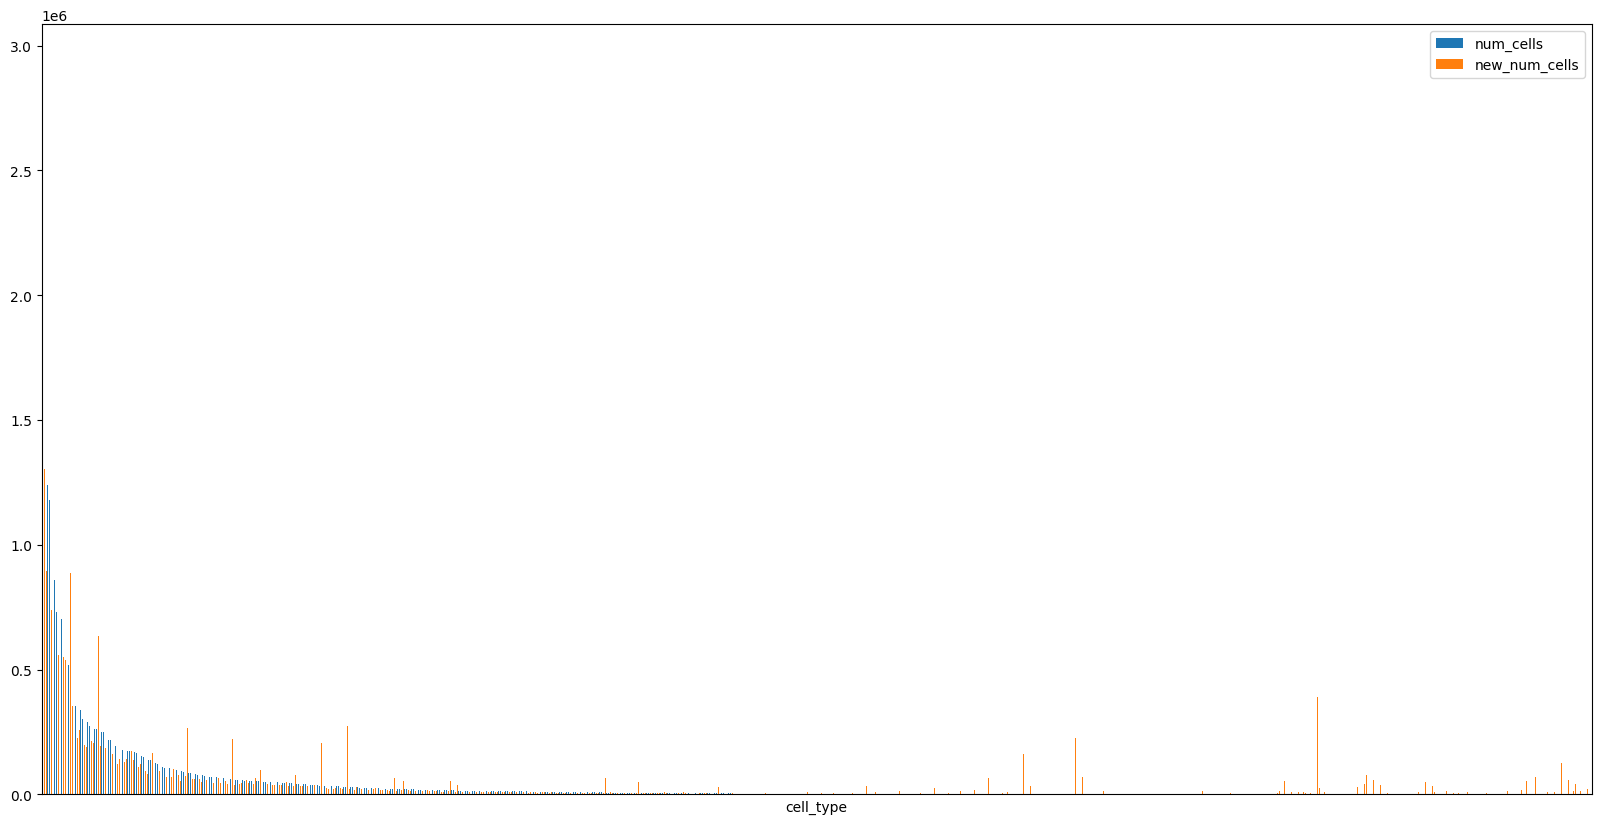

In [64]:
df.sort_values(by="num_cells", ascending=False).plot.bar(x="cell_type", y=["num_cells", "new_num_cells"], figsize=(20, 10))
# remove x-ticks label
plt.xticks([])

(0.1, 10000000.0)

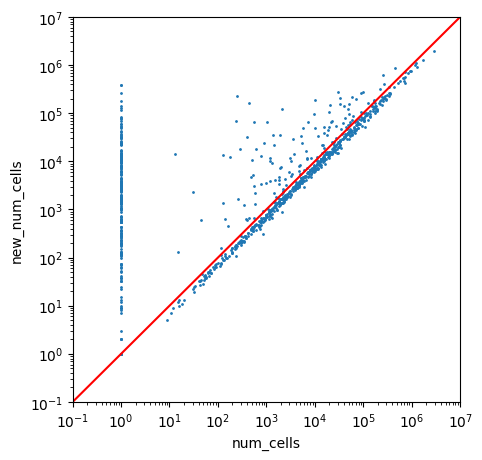

In [65]:
_df = df.copy()
_df["num_cells"] = 1 + df["num_cells"]
_df["new_num_cells"] = 1 + df["new_num_cells"]
_df.plot.scatter(x="num_cells", y="new_num_cells", figsize=(5, 5), s=1)
plt.plot([0, 1e7], [0, 1e7], color="red")
plt.loglog()
plt.xlim(0.1, 1e7)
plt.ylim(0.1, 1e7)

## combine ontologies

In [61]:
cell_type_ontology_data = torch.load("cell_type_ontology_data.pt")
tissue_onotology_data = torch.load("tissue_ontology_data.pt")
development_stage_onotology_data = torch.load("development_stage_ontology_data.pt")
disease_onotology_data = torch.load("disease_ontology_data.pt")
sex_onotology_data = torch.load("sex_ontology_data.pt")

/tmp/ipykernel_2984670/2248219605.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cell_type_ontology_data = torch.load("cell_type_ontology_data.pt")
/tmp/ipykernel_29846

In [62]:
ontology_infos = {
    "cell_type": cell_type_ontology_data,
    "tissue": tissue_onotology_data,
    "development_stage": development_stage_onotology_data,
    "disease": disease_onotology_data,
    "sex": sex_onotology_data,
}

In [63]:
cell_type_ontology_data["names"][:3]

['CL:0000540', 'CL:0000101', 'CL:0000001']

In [64]:
torch.save(ontology_infos, "ontology_infos.pt")